# Приложение знакомств

Есть приложение для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

<b>Задача</b>

Оценить, правда ли, что новый алгоритм улучшил качество сервиса и стоит ли включать новую систему поиска анкет на всех пользователей.

<b>Данные</b>

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

## Загрузка и изучение

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import pingouin as pg
import scipy.stats as ss
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

import warnings

warnings.filterwarnings('ignore')

In [2]:
# устанавливаем размер графиков
sns.set(rc={'figure.figsize':(10,6)})

In [3]:
data = pd.read_csv('dating_data.csv')

In [4]:
data.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [6]:
# посмотрим на кол-во юзеров в разных группах - неравномерное распределение
data.group.value_counts()

1    9722
0    4792
Name: group, dtype: int64

In [7]:
# кол-во уникальных юзеров в разных группах с разным мэтчем
data.groupby(['group', 'is_match'], as_index=False).agg({'user_id_1': 'nunique', 'user_id_2': 'nunique'})

,group,is_match,user_id_1,user_id_2
0,0,0,501,501
1,0,1,422,422
2,1,0,499,499
3,1,1,498,498


## Соотношение мэтчей к не-мэтчам

Сначала проверим гипотезу, что соотношение мэтчей с не-мэтчами в новом алгоритме изменилось. Если доля мэтчей увеличилась, значит алгоритм работает лучше.

In [8]:
# посчитаем кол-во мэтчей/не-мэтчей в разных группах
gr_m = pd.crosstab(data.group, data.is_match)
gr_m

is_match,0,1
group,,
0,3858,934
1,5813,3909


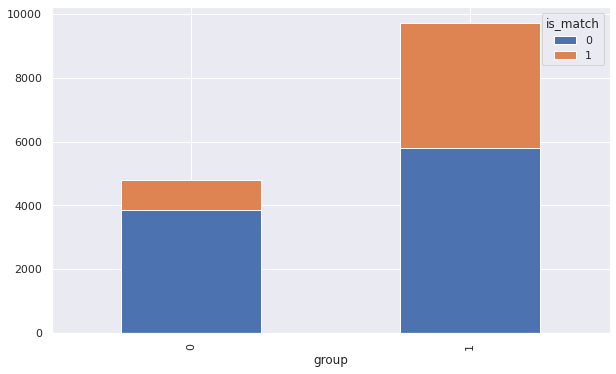

In [9]:
# доля мэтчей/не-мэтчей в разных группах, визуально есть разница между 0 и 1 группой
gr_m.plot(kind='bar', stacked=True);

Проверим нулевую гипотезу H0 о том, что доля мэтчей в группах не изменилась. У нас две категориальные переменные, воспользуемся критерием хи-квадрат.

In [10]:
stat, p, dof, expected = chi2_contingency(gr_m)

In [11]:
print(f'Значение p-value: {p}')

Значение p-value: 1.4418299163662586e-136


Значение p-value сильно меньше 0, значит мы может отклонить нулевую гипотезу об одинаковой доле мэтчей. Получили стат.значимые различия в доле мэтчей при работе разных алгоритмов.

## Количество мэтчей на каждого пользователя

Проверим нулевую гипотезу, что среднее количество мэтчей на каждого пользователя для нового алгоритма не изменилось.

In [12]:
# посчитаем кол-во мэтчей для каждого пользователя в разных группах на примере user_id_1
match_user1 = data.query('is_match == 1').groupby(['group', 'user_id_1'], as_index=False).size()\
    .rename(columns=({'size': 'num_match'}))
match_user1

,group,user_id_1,num_match
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
915,1,987,8
916,1,992,8
917,1,993,6
918,1,998,10


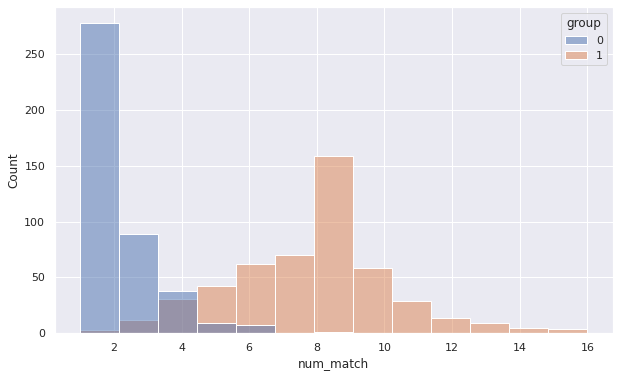

In [14]:
# визуализируем данные двух распределений, видим явные различия
sns.histplot(data=match_user1, x='num_match', hue='group');

In [15]:
# данные в контрольной группе распределены ненормально, в тестовой группе распределение нормальное
print(ss.normaltest(match_user1.query('group == 0').num_match))
print(ss.normaltest(match_user1.query('group == 1').num_match))

NormaltestResult(statistic=103.74972623982833, pvalue=2.958238586106499e-23)
NormaltestResult(statistic=3.505947740768115, pvalue=0.1732579299254646)


In [16]:
# t-test
pg.ttest(x=match_user1.query('group == 0').num_match,
        y=match_user1.query('group == 1').num_match)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-45.232978,744.211281,two-sided,9.229585e-216,"[-5.88, -5.39]",2.843535,3.166e+231,1.0


In [17]:
# проверим критерий Манна-Уитни
pg.mwu(x=match_user1.query('group == 0').num_match,
        y=match_user1.query('group == 1').num_match)

,U-val,alternative,p-val,RBC,CLES
MWU,3944.5,two-sided,1.570060e-141,0.962461,0.018769


Значение p-value в t-тестах очень маленькое, у нас есть все основания отклонить нулевую гипотезу об одинаковом среднем количестве мэтчей на пользоветеля.

## Вывод

В ходе данной работы мы проверили две нулевые гипотезы:
- соотношение мэтчей к не-мэтчам не изменилось после внедрения нового алгоритма
- среднее количество мэтчей на пользователя не изменилось после внедрения нового алгоритма

Проверили их с помощью:
- критерия хи-квадрат
- t-test и критерия Манна-Уитни для сравнения средних в двух выборках

Обе эти гипотезы не подтвердились и мы смогли стат.значимо отклонить их:
- соотношение мэтчей к не-мэтчам увеличилось
- среднее количество мэтчей на пользователя увеличилось

Следовательно новый алгоритм улучшает работу приложения, его можно внедрять на всех пользователей.